In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



# Multiple linear regression model and Data Loading functions

In [6]:
# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    #remove weekends

    print(data.head())
    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    data['50_sma'] = data['Close'].rolling(window=50).mean() #add 50 moving average
    data['200_sma'] = data['Close'].rolling(window=200).mean() #add 200 moving average
    data['12_ema'] =  data['Close'].ewm(span=12, adjust=False).mean()
    data['26_ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    data['MACD_line'] = data['12_ema']-data['26_ema'] # calculate the MACD line
    data['Signal_line'] = data['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    data['MACD_histogram'] = data['MACD_line'] - data['Signal_line']

    # Data Processing: Add target variable: closing price at the next time step
    data['NextTimeStepClosing'] = data['Close'].shift(-1) #shift closing price to create target

    data = data.dropna() # drop rows that have NA

    #select subset of data 
    data = data[-3500:]

    # Features: data of the current time step
    time = data['Time']
    X = data[['Open','High', 'Low', 'Close', 'Volume', '50_sma','200_sma']]  #features

    Y = data['NextTimeStepClosing']    #target - closing price of next time

    return X, Y, time

# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Data loading, Model Training and Performance Evaluation

In [164]:
# Load data
file_path = './Data/EURUSD_D1.csv'  # Replace with your CSV file path
X, y, time = load_data(file_path)

# Split data into training and test sets
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time,  test_size=0.2, random_state=42, shuffle=False)

sma_50_test = X_test['50_sma']
sma_200_test = X_test['200_sma']

# Standardize features - unless volume added, not needed: done so model can weigh each feature fairly
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, y_train)

# Make Forecast
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mbe = np.mean(y_pred_test - y_test) # mean bias error
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}\nTest MAE: {test_mae*100}%\nTest MBE: {test_mbe*100}% \nTest Coefficient of determination:{test_r2}')

'''
Data Processing: Re-Align test data and time and reset index
'''
y_test = y_test.reset_index(drop=True).iloc[1:] # exclude first row and reset index
time_test = time_test.reset_index(drop=True).iloc[1:]
y_pred_test = pd.Series(y_pred_test).shift(1) #convert prediction to a series
y_pred_test = y_pred_test.dropna()

# Re-align 50 EMA to match the test set
sma_50_test = sma_50_test.reset_index(drop=True).iloc[1:]
sma_200_test = sma_200_test.reset_index(drop=True).iloc[1:]


#Construct dataframe for easy plotting 
resultsDataFrame= pd.DataFrame({
    'Date and Time': time_test,
    'Actual closing': y_test,
    'Fore. Closing': y_pred_test,
    '50 SMA': sma_50_test,
    '200 SMA': sma_200_test

})


        Time     Open     High      Low    Close  Volume
0 2008-08-01  1.55575  1.55886  1.55142  1.55609  755330
1 2008-08-03  1.55638  1.55790  1.55586  1.55658   76728
2 2008-08-04  1.55662  1.56306  1.55526  1.55638  858293
3 2008-08-05  1.55624  1.55646  1.54442  1.54640  858740
4 2008-08-06  1.54650  1.55167  1.53956  1.54195  850798
Training MSE: 3.5476320960087376e-05
Test MSE: 3.233775681154524e-05
Test MAE: 0.41949199744721166%
Test MBE: -0.03181225413805638% 
Test Coefficient of determination:0.9704992866196809


# Plot of Prediction and Forecasted Price

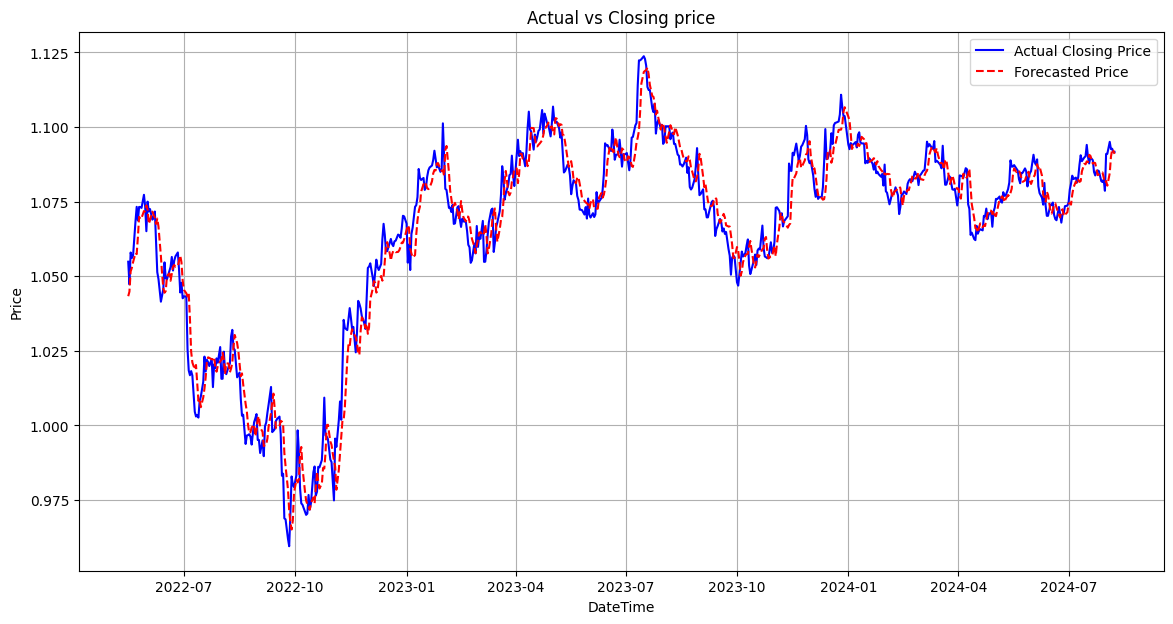

In [165]:
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 EMA', color='green', linestyle='-')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='50 EMA', color='blue', linestyle='-')

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Closing price')
plt.legend()
plt.grid(True)
plt.show()

# Trading strategy and Signal generation

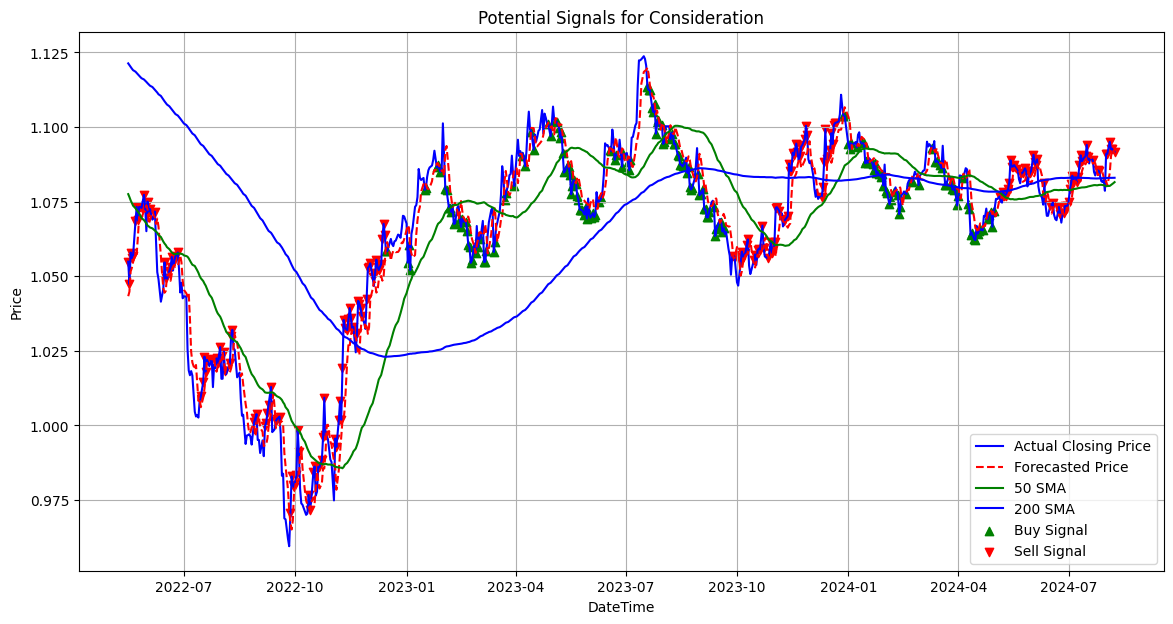

In [166]:
#generate trading signals -  store list of tuples
buy_signals =[]
sell_signals =[]


for i in range(len(y_test)):
    # Check if the 50 SMA is above the 200 SMA for a buy signal
    if (resultsDataFrame['50 SMA'].iloc[i] > resultsDataFrame['200 SMA'].iloc[i]):
        # Enter long position if predicted close > actual close and 50SMA > 200SMA
        if y_pred_test.iloc[i] > y_test.iloc[i]:
            buy_signals.append((time_test.iloc[i], y_test.iloc[i]))
            sell_signals.append((None, None))
        else:
            buy_signals.append((None, None))
            sell_signals.append((None, None))
    
    # Check if the 50 SMA is below the 200 SMA for a sell signal
    elif (resultsDataFrame['50 SMA'].iloc[i] < resultsDataFrame['200 SMA'].iloc[i]):
        # Enter short position if predicted close < actual close and 50SMA < 200SMA
        if y_pred_test.iloc[i] < y_test.iloc[i]:
            sell_signals.append((time_test.iloc[i], y_test.iloc[i]))
            buy_signals.append((None, None))
        else:
            buy_signals.append((None, None))
            sell_signals.append((None, None))
    
    # If neither condition is met, no trade opportunity
    else:
        buy_signals.append((None, None))
        sell_signals.append((None, None))

# Extract times and prices for plotting
buy_times = [signal[0] for signal in buy_signals if signal[0] is not None]
buy_prices = [signal[1] for signal in buy_signals if signal[1] is not None]
sell_times = [signal[0] for signal in sell_signals if signal[0] is not None]
sell_prices = [signal[1] for signal in sell_signals if signal[1] is not None]


# Plot buy and sell signals
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'blue',linestyle='--')

plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 SMA', color='green', linestyle='-')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='200 SMA', color='blue', linestyle='-')


plt.scatter(buy_times, buy_prices, marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_times, sell_prices, marker='v', color='red', label='Sell Signal', alpha=1)

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Potential Signals for Consideration')
plt.legend()
plt.grid(True)
plt.show()


# Trade Execution and Returns evaluation - BackTesting

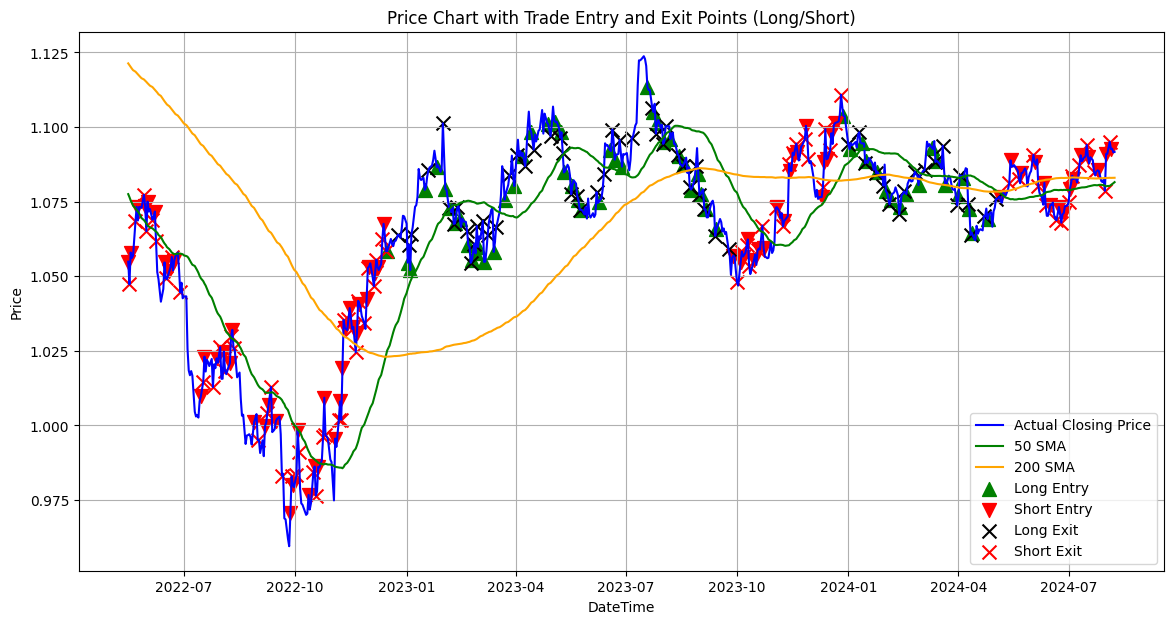

Total Trades: 131
Winning Trades: 59
Losing Trades: 72
Win Rate: 45.04%
Cumulative Pips: -9.30


In [167]:
# Initialize variables for backtesting
capital = 100000  # Starting capital in dollars (or any unit)
position = None  # Keeps track of the current position ('long', 'short', or None)
entry_price = 0  # The price at which the position was entered
pips_per_trade = 0  # To track pips gained/lost in each trade
cumulative_pips = 0  # To track cumulative pips gained/lost over time
pips_list = []  # Track pips gained/lost per trade

# Initialize lists to track long and short entry points separately
long_entry_points = []  # For long positions
short_entry_points = []  # For short positions
exit_points = []  # For exit points (both long and short)

long_exit_points = []  # For long position exits
short_exit_points = []  # For short position exits

# Define take profit and stop loss (in pips)
take_profit_pips = 50
stop_loss_pips = 30

# Convert pips to actual price movement for EURUSD (1 pip = 0.0001)
pip_value = 0.0001

# Backtesting loop
for i in range(len(y_test)):
    # Buy Signal (Enter Long)
    if buy_signals[i][0] is not None and position is None:
        position = 'long'
        entry_price = y_test.iloc[i]
        entry_time = time_test.iloc[i]
        long_entry_points.append((entry_time, entry_price))  # Track long entry point

    # Sell Signal (Enter Short)
    elif sell_signals[i][0] is not None and position is None:
        position = 'short'
        entry_price = y_test.iloc[i]
        entry_time = time_test.iloc[i]
        short_entry_points.append((entry_time, entry_price))  # Track short entry point

    # Exit Long Position
    elif position == 'long':
        # Calculate pips gained
        price_diff = y_test.iloc[i] - entry_price
        pips_per_trade = price_diff / pip_value

        # Check if take profit or stop loss is hit
        if pips_per_trade >= take_profit_pips or pips_per_trade <= -stop_loss_pips:
            cumulative_pips += pips_per_trade
            pips_list.append(pips_per_trade)
            # exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track exit point
            long_exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track long exit point

            position = None  # Exit trade

    # Exit Short Position
    elif position == 'short':
        # Calculate pips gained (inverse for short)
        price_diff = entry_price - y_test.iloc[i]
        pips_per_trade = price_diff / pip_value

        # Check if take profit or stop loss is hit
        if pips_per_trade >= take_profit_pips or pips_per_trade <= -stop_loss_pips:
            cumulative_pips += pips_per_trade
            pips_list.append(pips_per_trade)
            # exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track exit point
            short_exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track short exit point

            position = None  # Exit trade

# Extract entry and exit times and prices for plotting
long_entry_times = [point[0] for point in long_entry_points]
long_entry_prices = [point[1] for point in long_entry_points]
short_entry_times = [point[0] for point in short_entry_points]
short_entry_prices = [point[1] for point in short_entry_points]

# exit_times = [point[0] for point in exit_points]
# exit_prices = [point[1] for point in exit_points]

long_exit_times = [point[0] for point in long_exit_points]
long_exit_prices = [point[1] for point in long_exit_points]
short_exit_times = [point[0] for point in short_exit_points]
short_exit_prices = [point[1] for point in short_exit_points]

# Plot the price chart with long and short entry points and exit points
plt.figure(figsize=(14, 7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 SMA', color='green', linestyle='-')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='200 SMA', color='orange', linestyle='-')

# Plot long entry points (e.g., green triangle)
plt.scatter(long_entry_times, long_entry_prices, marker='^', color='green', label='Long Entry', alpha=1, s=100)

# Plot short entry points (e.g., red triangle)
plt.scatter(short_entry_times, short_entry_prices, marker='v', color='red', label='Short Entry', alpha=1, s=100)

# Plot exit points (e.g., black cross)
# plt.scatter(exit_times, exit_prices, marker='x', color='black', label='Exit Point', alpha=1, s=100)

# Plot long exit points (e.g., black cross)
plt.scatter(long_exit_times, long_exit_prices, marker='x', color='black', label='Long Exit', alpha=1, s=100)

# Plot short exit points (e.g., blue cross)
plt.scatter(short_exit_times, short_exit_prices, marker='x', color='red',label='Short Exit', alpha=1, s=100 )

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Price Chart with Trade Entry and Exit Points (Long/Short)')
plt.legend()
plt.grid(True)
plt.show()

# After the loop: Analyze the strategy performance
total_trades = len(pips_list)
winning_trades = len([p for p in pips_list if p > 0])
losing_trades = total_trades - winning_trades
win_rate = winning_trades / total_trades if total_trades > 0 else 0

# Display the backtesting results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Cumulative Pips: {cumulative_pips:.2f}")



# Visualsizing Backtest results

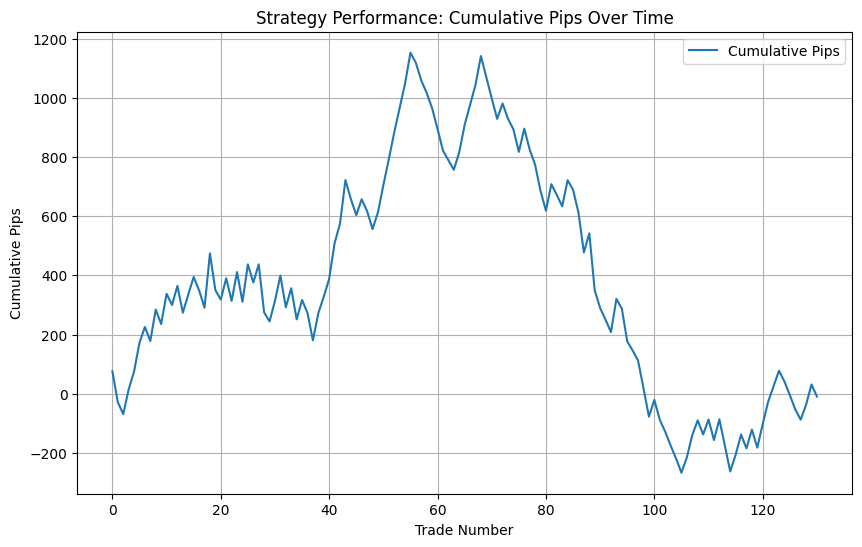

In [168]:
# Plot cumulative pips over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(pips_list)), [sum(pips_list[:i+1]) for i in range(len(pips_list))], label='Cumulative Pips')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Pips')
plt.title('Strategy Performance: Cumulative Pips Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Part 2: Data Inspection

               Open     High      Low    Close  Volume  Close_diff
Time                                                              
2008-08-01  1.55575  1.55886  1.55142  1.55609  755330         NaN
2008-08-03  1.55638  1.55790  1.55586  1.55658   76728     0.00049
2008-08-04  1.55662  1.56306  1.55526  1.55638  858293    -0.00020
2008-08-05  1.55624  1.55646  1.54442  1.54640  858740    -0.00998
2008-08-06  1.54650  1.55167  1.53956  1.54195  850798    -0.00445


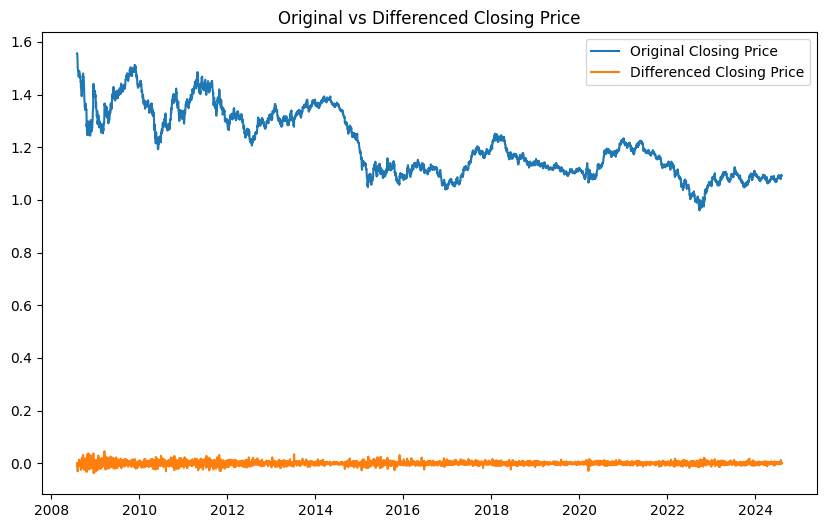

In [3]:
# Data loading
def data_loader(filepath):
    data = pd.read_csv(filepath)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    return data

#select one feature
def featureEngineering(data, n_past=1):
    X = []
    Y= []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i, -3].values)  # Select n_past number of rows for the closing price
        Y.append(data.iloc[i, -3])  # The target value

    feature_columns = [f'n_previous_{i}' for i in range(1, n_past+1)]
    X_df = pd.DataFrame(X, columns=feature_columns)
    Y_df = pd.DataFrame(Y, columns=['response'])

    updatedDataset = pd.concat([X_df, Y_df], axis=1)

    return updatedDataset, X_df,Y_df

filepath = './Data/EURUSD_D1.csv' 
datasetX = data_loader(filepath)

datasetX['Time'] = pd.to_datetime(datasetX['Time'],format='%Y-%m-%d %H:%M:%S')
datasetX.set_index('Time', inplace=True)

# Make the target (Closing price) stationary
datasetX['Close_diff'] = datasetX['Close'].diff()  # First difference of Closing price
print(datasetX.head())
datasetX.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(datasetX['Close'], label='Original Closing Price')
plt.plot(datasetX['Close_diff'], label='Differenced Closing Price')
plt.title('Original vs Differenced Closing Price')
plt.legend()
plt.show()

# Univariate FORECASTING USING N>1 previous time steps

Training MSE: 0.0002170201406692796
Test MSE: 0.00016276183493702426
Test MAE: 1.0384711554327033%
Test MBE: 0.9287218229280482% 
Test Coefficient of determination:0.9364209519721273


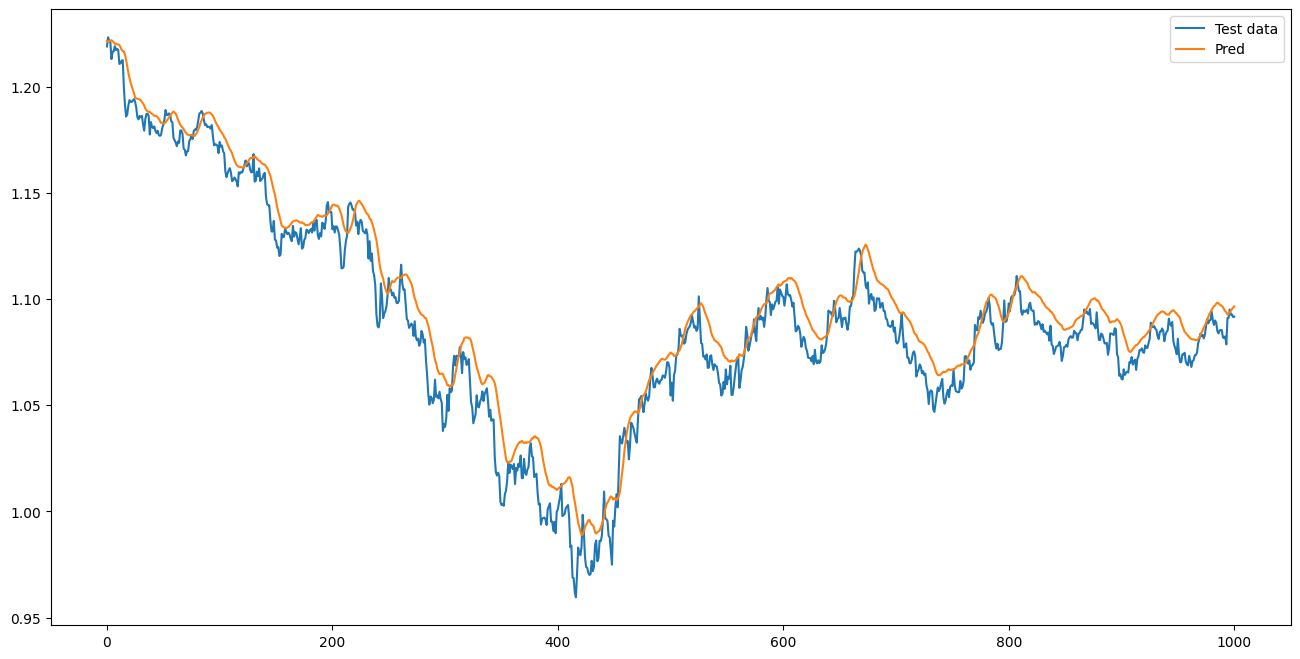

 d100 type: <class 'numpy.ndarray'>


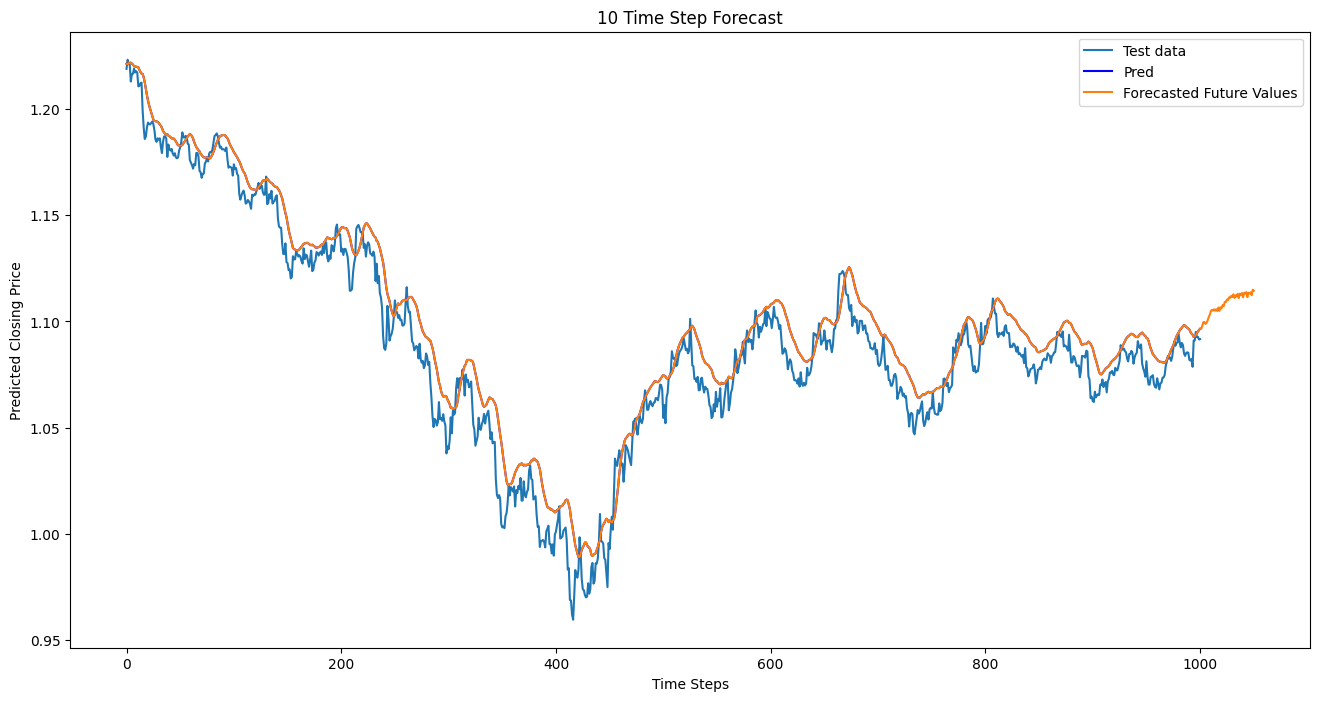

In [7]:

#return dataset
featuresAndresponse, X, Y = featureEngineering(datasetX, 10)

#data split
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=42, shuffle=False)

# Reshape y_train and y_test from DataFrame to 1D array or Series
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()    

#scale data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, y_train)

# Make Forecast
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mbe = np.mean(y_pred_test - y_test) # mean bias error
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}\nTest MAE: {test_mae*100}%\nTest MBE: {test_mbe*100}% \nTest Coefficient of determination:{test_r2}')

plt.figure(figsize=(16, 8))
plt.plot(y_test,label='Test data')
plt.plot(y_pred_test, label='Pred')
plt.legend()
plt.show()

# Perform future forecasting
test_last_100 =[]
test_last_100 = X_test.iloc[-1].to_numpy()  # Use the last row of X_test (100 previous time steps) - if using STD scalar , comment out
# test_last_100 = X_test[-1]
print(f' d100 type: {type(test_last_100)}')
forecastedRate = []

n_future = 50  # Forecast 10 time steps ahead
for i in range(n_future):
    y_predict = model.predict(test_last_100[-10:])  # Predict next time step
    forecastedRate.append(y_predict)  # Store prediction

    # Update test_last_100 to include the new prediction and remove the oldest value
    test_last_100 = np.roll(test_last_100, -1)  # Shift values left
    test_last_100 = np.append(test_last_100, y_predict)  # Add the new prediction at the end

y_pred_combined = np.concatenate([y_pred_test, forecastedRate])

# Plot the forecasted results
plt.figure(figsize=(16, 8))
plt.plot(y_test,label='Test data')
plt.plot(y_pred_test, label='Pred', color='blue')
plt.plot(y_pred_combined, label='Forecasted Future Values')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Closing Price')
plt.title('10 Time Step Forecast')
plt.legend()
plt.show()




# Statistical test

In [ ]:
from statsmodels.tsa.stattools import adfuller

#stationarity test
print(datasetX.iloc[:, -2])
result = adfuller(datasetX.iloc[:, -2].values, autolag='AIC')
print(f"ADF statistics: {result[0]}\nP-value:{result[1]}")

print(f"Critical values:")
for key, value in result[4].items():
    print('\t%s: %.3f'%(key, value))


# Multivariate forecasting Approach

In [ ]:
# Feature Engineering

def multivariateFeatureEngineering(updatedDataset):
    updatedDataset['Time'] = pd.to_datetime(updatedDataset['Time'],format='%Y-%m-%d %H:%M:%S')
    
    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    #Trend following Indicators:

    #SMA
    updatedDataset['50_sma'] = updatedDataset['Close'].rolling(window=50).mean() 
    updatedDataset['200_sma'] = updatedDataset['Close'].rolling(window=200).mean() 

    #EMA

    
    #MACD
    updatedDataset['12_ema'] = updatedDataset['Close'].ewm(span=12, adjust=False).mean()
    updatedDataset['26_ema'] = updatedDataset['Close'].ewm(span=26, adjust=False).mean()
    updatedDataset['MACD_line'] = updatedDataset['12_ema']-updatedDataset['26_ema'] # calculate the MACD line
    updatedDataset['Signal_line'] = updatedDataset['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    updatedDataset['MACD_histogram'] = updatedDataset['MACD_line'] - updatedDataset['Signal_line']

    #ADX


    #Momentum indicators

    #Volatility indicators

   
    updatedDataset = updatedDataset.dropna() # drop rows that have NA


    return updatedDataset
